## Connect to google drive using PyDrive API

In [0]:
# Connect to google Drive

!pip install -U -q PyDrive

import tensorflow as tf
import timeit

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Save the data.zip (45 GB) to drive, to avoid downloading the dataset after every 12 h
# Upload file to google drive from the colab notebook's "current files"
uploaded = drive.CreateFile({'title': 'sample.zip'})

# Change the name of the file to the actual file
uploaded.SetContentFile('sample.zip')

# Trigger the upload (will take around 10 mins)
uploaded.Upload()

# Will show the file ID on successful upload to drive.
print('Uploaded file with ID {}'.format(uploaded.get('id')))



---



## Download and extract data into Colab Environment

In [2]:
!ls -l

total 4
drwxr-xr-x 1 root root 4096 Apr 30 16:29 datalab


In [0]:
#@title Enter Authenticated URL for dataset { display-mode: "form" }
URL = "https://storage.googleapis.com/kaggle-datasets/4667/7773/sample.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1525502804&Signature=V8r4XzI6BmpbBpUdvNV5M4B2OTWcP8wi7FCSD0VmHl46Qn%2F0m9XJwTVej9kd432wD%2FggouZpLcs1eG8SZvPN21K7ssrKbB%2FaJDKCcGQNZFVTmaxEtcCacrAyvk0DBQupTuDU63at3BU1%2FVcZ1DzJGmIYlZIf9x7AHsEwrppdWhpLpt309SMdRT8Ed6OjHbIiUcEWB4xGM87nMFl34srv%2BOBjnnlNtkd7OVcZ1J4yRb6kBxclr%2FSNn1WA0GIPcFrgx%2B1muRPOXIMo%2Fu6LJ9ggI8ZSQpnTRGi7hwWdhi%2F%2BUfAiny723%2Bx8qgDxIWOZ6PQvf1a9fLDBRycW%2FeDpnYOwhQ%3D%3D" #@param {type:"string"}

In [0]:
!rm -rf /content/DATA/
!wget '$URL' -O data.zip
!mkdir DATA
!unzip data.zip -d DATA
%cd DATA/
!unzip '*.zip'
!rm *.zip
%cd ..
!rm data.zip
![ -e DATA/sample_labels.csv ] && mv DATA/sample_labels.csv DATA/Data_Entry_2017.csv
!mkdir /content/DATA/images2

In [5]:
!ls

DATA  datalab


## Preprocessing

In [0]:
# import dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import cv2
!rm -rf /content/DATA/images2
!mkdir /content/DATA/images2

In [0]:
data = pd.read_csv('/content/DATA/Data_Entry_2017.csv')
data.info()


# Constant dicts/lists
patho_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia','No Finding']
gender_map = {'M' :0 ,'F' :1 }
VP_map     = {'PA':0 ,'AP':1 }

In [0]:
def clean_age(df) :
  df['Age Type']                            = df['Patient Age'].apply(lambda x: x[-1:])
  df['Age']                                 = df['Patient Age'].apply(lambda x: x[:-1]).astype(int)
  df.loc[df['Age Type'] == 'M',['Age']]     = df[df['Age Type']=='M']['Age'].apply(lambda x: round(x/12.)).astype(int)
  df.loc[df['Age Type'] == 'D',['Age']]     = df[df['Age Type']=='D']['Age'].apply(lambda x: round(x/365.)).astype(int)
  df.drop(['Patient Age','Age Type'],axis=1,inplace=True)
  return df
  

def preprocess(df,G_map,V_map,D_list,MIN_CASES):
  
  ##### STEP 1: get rid of | seperated diseases
  #######################################################################
  # Convert | seperated diseases to columns with binary values
  for dis in D_list :
    df[dis] = df['Finding Labels'].apply(lambda x: 1 if dis in x else 0)
  #######################################################################
  
  
#   ##### STEP 2: clean the age,gender,view position columns
#   #######################################################################
#   # Patien Age is in years,days,months
#   df = clean_age(df)
#   # Converts gender,view position to int
#   df.replace({'Patient Gender':G_map, 'View Position':V_map},inplace=True)
#   #######################################################################
  
  
  # Apply CLAHE(Contrast Limited Adaptive Histogram Equilisation)
  orig_img_path = [x for x in glob.glob(os.path.join('/content','DATA','images','*.png'))]
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  
  for img in orig_img_path:
        base = os.path.basename(img)
        full_size_image = cv2.imread(img,0)
#       full_size_image = cv2.resize(full_size_image, (128,128), interpolation=cv2.INTER_CUBIC)
        cl1 = clahe.apply(full_size_image)
        last='/content/DATA/images/'+base
        cv2.imwrite(last,cl1)
  
  
  ##### STEP 3: map image location with correct datapoint
  #######################################################################
  # abs path of all the png images
  all_image_paths = {os.path.basename(x): x for x in orig_img_path}
  # Maps Image Index with its respective path
  df['path'] = df['Image Index'].map(all_image_paths.get)
  #######################################################################
  
  ##### STEP 4: choose diseases which have atleast MIN_CASES
  #######################################################################
  all_labels = [c_label for c_label in patho_list if data[c_label].sum() > MIN_CASES]
  #######################################################################
  
  
  ##### STEP 5: Convert the considered labels to one hot encoding
  #######################################################################
  # data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
  data['disease_vec'] = data[all_labels].values.tolist()
  #######################################################################
  

  ##### STEP 6: Drop unnecessary columns
  #######################################################################
  drop_list = ['OriginalImageWidth','OriginalImageHeight','OriginalImagePixelSpacing_x','OriginalImagePixelSpacing_y']
  df = df[['Image Index','Finding Labels','path','disease_vec']]
  #######################################################################
  
  
  ##### STEP 7: normalise the data
  #######################################################################
  # since the dataset is very unbiased, we can resample it to be a more reasonable collection
  # weight is 0.1 + number of findings
  num_diseases = df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
  num_diseases /= num_diseases.sum()
  df = df.sample(np.shape(df)[0],weights=num_diseases)
  #######################################################################
  
  
  return df,all_labels

In [0]:
data,all_labels = preprocess(data, gender_map, VP_map, patho_list,0)

In [0]:
!ls DATA/images2

## IMPORTING IMAGES & VISUALISATION

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

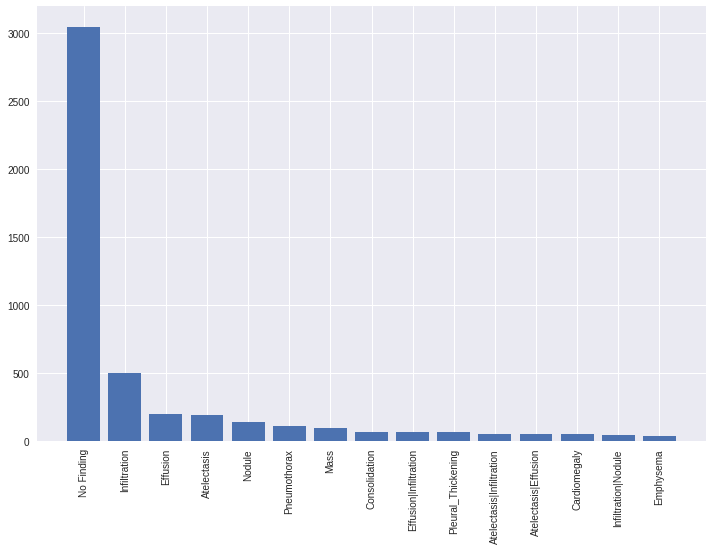

In [12]:
label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

# Processing

In [13]:
# TRAIN/TEST split

from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(data, 
                                      test_size = 0.25, 
                                      random_state = 2018,
                                      stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 4204 validation 1402


In [0]:
train_df

### Data Augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(
                              samplewise_center            = True, 
                              samplewise_std_normalization = True, 
                              horizontal_flip              = True, 
                              vertical_flip                = False, 
                              height_shift_range           = 0.05, 
                              width_shift_range            = 0.1, 
                              rotation_range               = 5, 
                              shear_range                  = 0.1,
                              fill_mode                    = 'reflect',
                              zoom_range                   = 0.15
                             )

In [0]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode = 'sparse', **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [17]:
train_gen = flow_from_dataframe(core_idg,train_df, 
                                path_col    = 'path',
                                y_col       = 'disease_vec', 
                                target_size = IMG_SIZE,
                                color_mode  = 'grayscale',
                                batch_size  = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                                path_col    = 'path',
                                y_col       = 'disease_vec', 
                                target_size = IMG_SIZE,
                                color_mode  = 'grayscale',
                                batch_size  = 256) 

# we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm

test_X, test_Y = next(flow_from_dataframe(core_idg, valid_df, 
                                          path_col    = 'path',
                                          y_col       = 'disease_vec', 
                                          target_size = IMG_SIZE,
                                          color_mode  = 'grayscale',
                                          batch_size  = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4204 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1402 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1402 images


### Visualising Training Data(Augmented)

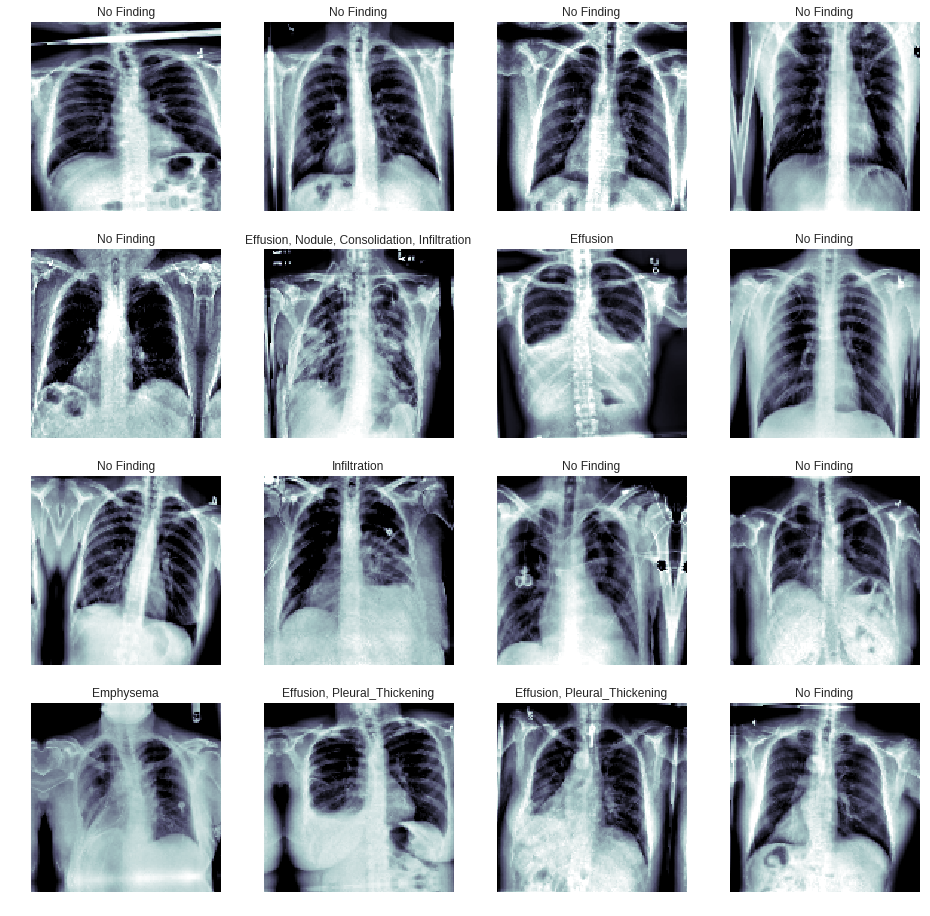

In [18]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) if n_score>0.5]))
    c_ax.axis('off')

### MOBILE-NET MODEL

In [0]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation
from keras.models import Sequential
from keras.utils.generic_utils import get_custom_objects

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], include_top = False, weights = None)
multi_disease_model  = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy', 'mae'])


In [70]:
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1024)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 15)                7695      
Total params: 3,760,783
Trainable params: 3,738,895
Non-trainable params: 21,888
_____________________________________________________________

### To get loss/accuracy during training

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import History 

weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor  ="val_loss", 
                      mode     ="min", 
                      patience =3)

history = History()

callbacks_list = [checkpoint, early, history]


### Training

In [79]:
multi_disease_model.fit_generator(
                                  train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs          = 40, 
                                  callbacks       = callbacks_list
                                 )

Epoch 1/40
100/100 [==============================] - 47s 474ms/step - loss: 0.2070 - binary_accuracy: 0.9295 - mean_absolute_error: 0.1135 - val_loss: 0.2168 - val_binary_accuracy: 0.9250 - val_mean_absolute_error: 0.1035

Epoch 00001: val_loss did not improve from 0.20809
Epoch 2/40
100/100 [==============================] - 46s 461ms/step - loss: 0.2060 - binary_accuracy: 0.9308 - mean_absolute_error: 0.1123 - val_loss: 0.2279 - val_binary_accuracy: 0.9264 - val_mean_absolute_error: 0.0979

Epoch 00002: val_loss did not improve from 0.20809
Epoch 3/40
 66/100 [==================>...........] - ETA: 15s - loss: 0.2096 - binary_accuracy: 0.9284 - mean_absolute_error: 0.1160

100/100 [==============================] - 46s 464ms/step - loss: 0.2100 - binary_accuracy: 0.9280 - mean_absolute_error: 0.1160 - val_loss: 0.2121 - val_binary_accuracy: 0.9271 - val_mean_absolute_error: 0.1097

Epoch 00003: val_loss did not improve from 0.20809
Epoch 4/40
100/100 [==============================] - 46s 463ms/step - loss: 0.2036 - binary_accuracy: 0.9312 - mean_absolute_error: 0.1116 - val_loss: 0.2136 - val_binary_accuracy: 0.9264 - val_mean_absolute_error: 0.1040

Epoch 00004: val_loss did not improve from 0.20809
Epoch 5/40
 82/100 [=======================>......] - ETA: 7s - loss: 0.2029 - binary_accuracy: 0.9306 - mean_absolute_error: 0.1116

100/100 [==============================] - 46s 461ms/step - loss: 0.2052 - binary_accuracy: 0.9298 - mean_absolute_error: 0.1131 - val_loss: 0.2103 - val_binary_accuracy: 0.9279 - val_mean_absolute_error: 0.1112

Epoch 00005: val_loss did not improve from 0.20809
Epoch 6/40
100/100 [==============================] - 46s 460ms/step - loss: 0.2010 - binary_accuracy: 0.9306 - mean_absolute_error: 0.1107 - val_loss: 0.2151 - val_binary_accuracy: 0.9269 - val_mean_absolute_error: 0.1072

Epoch 00006: val_loss did not improve from 0.20809
Epoch 7/40
 83/100 [=======================>......] - ETA: 7s - loss: 0.2048 - binary_accuracy: 0.9288 - mean_absolute_error: 0.1133

100/100 [==============================] - 46s 463ms/step - loss: 0.2050 - binary_accuracy: 0.9287 - mean_absolute_error: 0.1134 - val_loss: 0.2098 - val_binary_accuracy: 0.9276 - val_mean_absolute_error: 0.1177

Epoch 00007: val_loss did not improve from 0.20809
Epoch 8/40
100/100 [==============================] - 46s 464ms/step - loss: 0.2026 - binary_accuracy: 0.9317 - mean_absolute_error: 0.1115 - val_loss: 0.2104 - val_binary_accuracy: 0.9288 - val_mean_absolute_error: 0.1123

Epoch 00008: val_loss did not improve from 0.20809
Epoch 9/40
 85/100 [========================>.....] - ETA: 6s - loss: 0.2023 - binary_accuracy: 0.9309 - mean_absolute_error: 0.1118

100/100 [==============================] - 46s 459ms/step - loss: 0.2034 - binary_accuracy: 0.9311 - mean_absolute_error: 0.1117 - val_loss: 0.2127 - val_binary_accuracy: 0.9265 - val_mean_absolute_error: 0.1205

Epoch 00009: val_loss did not improve from 0.20809
Epoch 10/40
100/100 [==============================] - 46s 461ms/step - loss: 0.2009 - binary_accuracy: 0.9307 - mean_absolute_error: 0.1114 - val_loss: 0.2140 - val_binary_accuracy: 0.9265 - val_mean_absolute_error: 0.1169

Epoch 00010: val_loss did not improve from 0.20809


In [0]:
multi_disease_model.load_weights(weight_path)

### DEMO/TESTING

In [86]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)


1024/1024 [==============================] - 2s 2ms/step


### More Visualisations

In [0]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 100*np.mean(pred_Y,0), 100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

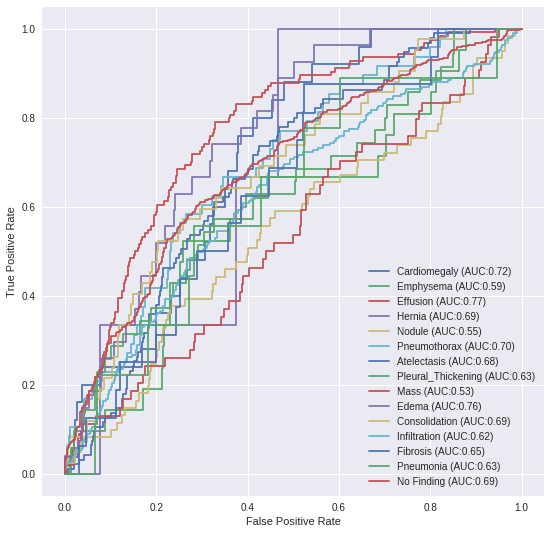

In [88]:
from sklearn.metrics import roc_curve, auc

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

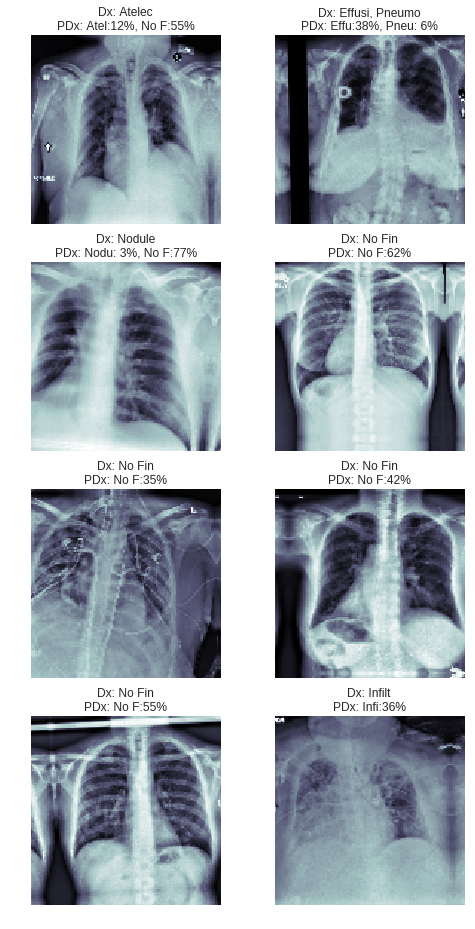

In [89]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (8,16))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, test_Y[idx]) if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, test_Y[idx], pred_Y[idx]) if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')


In [0]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(history.history['binary_accuracy'])

### Notes

Converts Finding data to str and gets OHE dummies using | as seperator
```
data['Finding Labels'].str.get_dummies('|')
disease_list = data['Finding Labels'].str.get_dummies('|').columns.values
```
IDEA 
Add a dummy so that all the columns/diseases are present in the testing set also.
```
df.loc[-1] = ['DUMMY','|'.join(D_list),-1,-1,-1,'M','PA',-1,-1,-1.0,-1.0,'NaN']
```
